In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt

In [4]:
import os
import function_training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import json

import numpy as np
import tensorflow as tf

from dataLoader import AnyDataset
import function_training
from function_training import confusion_matrix
from config import MLP_model,hyperparameters, args, CNN_model

numBands=100
bands_type="spin up"

import xgboost as xgb

Init Plugin
Init Graph Optimizer
Init Kernel


In [5]:
## # step 1. prepare dataset
# def json2inputlabel(data_json, bands_type="spin up"):
#     _bands_type = {"spin up": "spin_up_bands",
#                    "spin down": "spin_down_bands",
#                    "soc": "soc_bands"}
#     data_input_np = np.array(data_json[_bands_type[bands_type]]) # 100 x 400
#     # data_input_np = np.array(data_json[_bands_type[bands_type]]).flataten().T # 40000x1
#     data_label_np = np.array([data_json["new_label"]])
#     # data_label_np = np.array([data_json["layers_num"]])

#     return data_input_np, data_label_np

# step 1. prepare dataset
debug=False
def json2inputlabel(data_json, bands_type="spin up", 
                    gamma=False, MLP_input=False, layergroup_input=True):
    _bands_type = {"spin up": "spin_up_bands",
                   "spin down": "spin_down_bands",
                   "soc": "soc_bands"}
    
#     ## Original input bands
#     data_input_np = np.array(data_json[_bands_type[bands_type]])
    
    ## Trial: input 40*400 and take gamma point only
    data_input_np = np.array(data_json[_bands_type[bands_type]])
    
    if gamma:
        for pts in data_json["k_labels"]:
    #         print (pts[0], pts[1])
            if pts[0] == 'G':
                if debug:
                    print (pts[0], pts[1])

    #             if pts[1] != 0:
    #                 print (f'({pts[0]}, {pts[1]}) || layers num: {data_json["layers_num"]}')
                gamma_point = pts[1]
                break


        data_input_np = data_input_np[:,gamma_point]
        if debug:
            print (f'data_input_np: {data_input_np.shape}')
            
    if MLP_input:
        pass
#         #read model ==> input data ==> concat
#         MLP_label = model(data_input_np)
#         data_input_np = np.concatenate((data_input_np, MLP_label), axis=None)
            
    if layergroup_input:
        layergroup_number_input_np = np.array([data_json["layergroup_number"]])
        data_input_np = np.concatenate((data_input_np, layergroup_number_input_np), axis=None)
        
    ## labels
    data_label_np = np.array([data_json["new_label"]])

    return data_input_np, data_label_np

#take data and set batch size here
list_path = "./list_eigenvalue_norm_40x400_9classes_augment"
train_dataset = AnyDataset(f"{list_path}/actual/train_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=True)
test_dataset = AnyDataset(f"{list_path}/actual/test_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=False)
train_loader = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs, train_dataset.data_labels)).shuffle(train_dataset.len).batch(hyperparameters['batch_size'])
test_loader = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(hyperparameters['batch_size'])


Loading test set: 100%|███████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 655.35it/s]


Metal device set to: Apple M1 Pro


In [6]:
train_loader2 = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs,train_dataset.data_labels)).shuffle(train_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in train_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])

#     predict = np.argmax(model.predict(element), axis=-1)
#     label = np.array(labels).flatten()
    break

In [7]:
shape = element.numpy().shape
print (shape)
try:
    shape[2]
    element_flatten2D_train = element.numpy().reshape(shape[0],shape[1]*shape[2])
except IndexError:
    element_flatten2D_train = element.numpy().reshape(shape[0],shape[1])
# element_flatten2D_train = element.numpy().reshape(shape[0],shape[1]*shape[2])
labels1D_train = labels.numpy().flatten()

dtrain = xgb.DMatrix(element_flatten2D_train, label=labels1D_train)

(1000, 4001)


In [8]:
test_loader2 = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in test_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])

#     predict = np.argmax(model.predict(element), axis=-1)
#     label = np.array(labels).flatten()
    break

shape = element.numpy().shape
try:
    shape[2]
    element_flatten2D_test = element.numpy().reshape(shape[0],shape[1]*shape[2])
except IndexError:
    element_flatten2D_test = element.numpy().reshape(shape[0],shape[1])
# shape = element.numpy().shape
# element_flatten2D_test = element.numpy().reshape(shape[0],shape[1])
# element_flatten2D_test = element.numpy().reshape(shape[0],shape[1]*shape[2])
labels1D_test = labels.numpy().flatten()

dtest = xgb.DMatrix(element_flatten2D_test, label=labels1D_test)

In [10]:
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
###
# advanced: start from a initial base prediction
#
print('start running example to start from a initial prediction')
# specify parameters via map, definition are same as c++ version
# param = {'max_depth': 5, 'eta': 0.2, 'lambda':0, 'alpha':0, 'num_class': 9, 'objective':'multi:softmax', 'sampling_method':'gradient_based'}
param = {'max_depth': 30, 'eta': 0.02, 'lambda':0, 'alpha':0, 'num_class': args["load"]["numClasses"], 'objective':'multi:softmax', 'sampling_method':'gradient_based'}
# param = {'max_depth': 30, 'eta': 0.002, 'lambda':0, 'alpha':0, 'num_class': 5, 'objective':'multi:softmax'}
# train xgboost for 1 round
bst = xgb.train(param, dtrain, 3500, watchlist, early_stopping_rounds=50)
# Note: we need the margin value instead of transformed prediction in
# set_base_margin
# do predict with output_margin=True, will always give you margin values
# before logistic transformation
ptrain = bst.predict(dtrain)
ptest = bst.predict(dtest)

start running example to start from a initial prediction
[09:14:38] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-mlogloss:2.16050	train-mlogloss:2.12790
[1]	eval-mlogloss:2.12813	train-mlogloss:2.06113
[2]	eval-mlogloss:2.09797	train-mlogloss:1.99836
[3]	eval-mlogloss:2.06936	train-mlogloss:1.93972
[4]	eval-mlogloss:2.03813	train-mlogloss:1.88472
[5]	eval-mlogloss:2.01292	train-mlogloss:1.83167
[6]	eval-mlogloss:1.99039	train-mlogloss:1.78167
[7]	eval-mlogloss:1.97070	train-mlogloss:1.73379
[8]	eval-mlogloss:1.95123	train-mlogloss:1.68824
[9]	eval-mlogloss:1.93288	train-mlogloss:1.64450
[10]	eval-mlogloss:1.91490	train-mlogloss:1.60275
[11]	eval-mlogloss:1.89892	train-mlogloss:1.56262
[12]	eval-mlogloss:1.88494	train-mlogl

[156]	eval-mlogloss:1.22678	train-mlogloss:0.11514
[157]	eval-mlogloss:1.22639	train-mlogloss:0.11354
[158]	eval-mlogloss:1.22505	train-mlogloss:0.11196
[159]	eval-mlogloss:1.22509	train-mlogloss:0.11042
[160]	eval-mlogloss:1.22413	train-mlogloss:0.10890
[161]	eval-mlogloss:1.22364	train-mlogloss:0.10739
[162]	eval-mlogloss:1.22335	train-mlogloss:0.10592
[163]	eval-mlogloss:1.22282	train-mlogloss:0.10448
[164]	eval-mlogloss:1.22204	train-mlogloss:0.10308
[165]	eval-mlogloss:1.22085	train-mlogloss:0.10167
[166]	eval-mlogloss:1.22053	train-mlogloss:0.10032
[167]	eval-mlogloss:1.21987	train-mlogloss:0.09897
[168]	eval-mlogloss:1.21867	train-mlogloss:0.09764
[169]	eval-mlogloss:1.21748	train-mlogloss:0.09637
[170]	eval-mlogloss:1.21592	train-mlogloss:0.09509
[171]	eval-mlogloss:1.21433	train-mlogloss:0.09383
[172]	eval-mlogloss:1.21316	train-mlogloss:0.09258
[173]	eval-mlogloss:1.21204	train-mlogloss:0.09138
[174]	eval-mlogloss:1.21161	train-mlogloss:0.09019
[175]	eval-mlogloss:1.21106	tra

[317]	eval-mlogloss:1.17776	train-mlogloss:0.02492
[318]	eval-mlogloss:1.17787	train-mlogloss:0.02480
[319]	eval-mlogloss:1.17807	train-mlogloss:0.02467
[320]	eval-mlogloss:1.17859	train-mlogloss:0.02454
[321]	eval-mlogloss:1.17926	train-mlogloss:0.02443
[322]	eval-mlogloss:1.17966	train-mlogloss:0.02431
[323]	eval-mlogloss:1.17983	train-mlogloss:0.02419
[324]	eval-mlogloss:1.18023	train-mlogloss:0.02407
[325]	eval-mlogloss:1.18042	train-mlogloss:0.02395
[326]	eval-mlogloss:1.18074	train-mlogloss:0.02384
[327]	eval-mlogloss:1.18135	train-mlogloss:0.02373
[328]	eval-mlogloss:1.18165	train-mlogloss:0.02362
[329]	eval-mlogloss:1.18277	train-mlogloss:0.02350
[330]	eval-mlogloss:1.18336	train-mlogloss:0.02338
[331]	eval-mlogloss:1.18409	train-mlogloss:0.02328
[332]	eval-mlogloss:1.18449	train-mlogloss:0.02317
[333]	eval-mlogloss:1.18472	train-mlogloss:0.02307
[334]	eval-mlogloss:1.18530	train-mlogloss:0.02296
[335]	eval-mlogloss:1.18557	train-mlogloss:0.02286
[336]	eval-mlogloss:1.18607	tra

[478]	eval-mlogloss:1.22177	train-mlogloss:0.01474
[479]	eval-mlogloss:1.22201	train-mlogloss:0.01471
[480]	eval-mlogloss:1.22211	train-mlogloss:0.01467
[481]	eval-mlogloss:1.22210	train-mlogloss:0.01464
[482]	eval-mlogloss:1.22239	train-mlogloss:0.01461
[483]	eval-mlogloss:1.22261	train-mlogloss:0.01458
[484]	eval-mlogloss:1.22251	train-mlogloss:0.01455
[485]	eval-mlogloss:1.22280	train-mlogloss:0.01452
[486]	eval-mlogloss:1.22278	train-mlogloss:0.01449
[487]	eval-mlogloss:1.22308	train-mlogloss:0.01446
[488]	eval-mlogloss:1.22319	train-mlogloss:0.01443
[489]	eval-mlogloss:1.22361	train-mlogloss:0.01440
[490]	eval-mlogloss:1.22381	train-mlogloss:0.01437
[491]	eval-mlogloss:1.22417	train-mlogloss:0.01434
[492]	eval-mlogloss:1.22465	train-mlogloss:0.01431
[493]	eval-mlogloss:1.22482	train-mlogloss:0.01429
[494]	eval-mlogloss:1.22497	train-mlogloss:0.01426
[495]	eval-mlogloss:1.22530	train-mlogloss:0.01423
[496]	eval-mlogloss:1.22568	train-mlogloss:0.01420
[497]	eval-mlogloss:1.22586	tra

[639]	eval-mlogloss:1.25402	train-mlogloss:0.01138
[640]	eval-mlogloss:1.25391	train-mlogloss:0.01136
[641]	eval-mlogloss:1.25411	train-mlogloss:0.01135
[642]	eval-mlogloss:1.25436	train-mlogloss:0.01134
[643]	eval-mlogloss:1.25468	train-mlogloss:0.01132
[644]	eval-mlogloss:1.25462	train-mlogloss:0.01131
[645]	eval-mlogloss:1.25485	train-mlogloss:0.01130
[646]	eval-mlogloss:1.25493	train-mlogloss:0.01128
[647]	eval-mlogloss:1.25518	train-mlogloss:0.01127
[648]	eval-mlogloss:1.25552	train-mlogloss:0.01126
[649]	eval-mlogloss:1.25548	train-mlogloss:0.01125
[650]	eval-mlogloss:1.25590	train-mlogloss:0.01123
[651]	eval-mlogloss:1.25585	train-mlogloss:0.01122
[652]	eval-mlogloss:1.25593	train-mlogloss:0.01121
[653]	eval-mlogloss:1.25618	train-mlogloss:0.01120
[654]	eval-mlogloss:1.25643	train-mlogloss:0.01118
[655]	eval-mlogloss:1.25659	train-mlogloss:0.01117
[656]	eval-mlogloss:1.25680	train-mlogloss:0.01116
[657]	eval-mlogloss:1.25680	train-mlogloss:0.01114
[658]	eval-mlogloss:1.25713	tra

[800]	eval-mlogloss:1.27399	train-mlogloss:0.00972
[801]	eval-mlogloss:1.27416	train-mlogloss:0.00971
[802]	eval-mlogloss:1.27421	train-mlogloss:0.00970
[803]	eval-mlogloss:1.27440	train-mlogloss:0.00969
[804]	eval-mlogloss:1.27448	train-mlogloss:0.00968
[805]	eval-mlogloss:1.27444	train-mlogloss:0.00968
[806]	eval-mlogloss:1.27478	train-mlogloss:0.00967
[807]	eval-mlogloss:1.27495	train-mlogloss:0.00966
[808]	eval-mlogloss:1.27494	train-mlogloss:0.00965
[809]	eval-mlogloss:1.27515	train-mlogloss:0.00965
[810]	eval-mlogloss:1.27518	train-mlogloss:0.00964
[811]	eval-mlogloss:1.27530	train-mlogloss:0.00963
[812]	eval-mlogloss:1.27554	train-mlogloss:0.00962
[813]	eval-mlogloss:1.27555	train-mlogloss:0.00962
[814]	eval-mlogloss:1.27574	train-mlogloss:0.00961
[815]	eval-mlogloss:1.27587	train-mlogloss:0.00960
[816]	eval-mlogloss:1.27586	train-mlogloss:0.00959
[817]	eval-mlogloss:1.27564	train-mlogloss:0.00959
[818]	eval-mlogloss:1.27576	train-mlogloss:0.00958
[819]	eval-mlogloss:1.27574	tra

[961]	eval-mlogloss:1.28509	train-mlogloss:0.00869
[962]	eval-mlogloss:1.28497	train-mlogloss:0.00869
[963]	eval-mlogloss:1.28513	train-mlogloss:0.00869
[964]	eval-mlogloss:1.28508	train-mlogloss:0.00868
[965]	eval-mlogloss:1.28521	train-mlogloss:0.00868
[966]	eval-mlogloss:1.28524	train-mlogloss:0.00867
[967]	eval-mlogloss:1.28540	train-mlogloss:0.00867
[968]	eval-mlogloss:1.28540	train-mlogloss:0.00866
[969]	eval-mlogloss:1.28531	train-mlogloss:0.00865
[970]	eval-mlogloss:1.28563	train-mlogloss:0.00865
[971]	eval-mlogloss:1.28545	train-mlogloss:0.00864
[972]	eval-mlogloss:1.28549	train-mlogloss:0.00864
[973]	eval-mlogloss:1.28544	train-mlogloss:0.00864
[974]	eval-mlogloss:1.28563	train-mlogloss:0.00863
[975]	eval-mlogloss:1.28567	train-mlogloss:0.00863
[976]	eval-mlogloss:1.28569	train-mlogloss:0.00862
[977]	eval-mlogloss:1.28557	train-mlogloss:0.00862
[978]	eval-mlogloss:1.28568	train-mlogloss:0.00861
[979]	eval-mlogloss:1.28577	train-mlogloss:0.00861
[980]	eval-mlogloss:1.28587	tra

[1120]	eval-mlogloss:1.29055	train-mlogloss:0.00802
[1121]	eval-mlogloss:1.29051	train-mlogloss:0.00801
[1122]	eval-mlogloss:1.29058	train-mlogloss:0.00801
[1123]	eval-mlogloss:1.29060	train-mlogloss:0.00801
[1124]	eval-mlogloss:1.29066	train-mlogloss:0.00800
[1125]	eval-mlogloss:1.29056	train-mlogloss:0.00800
[1126]	eval-mlogloss:1.29063	train-mlogloss:0.00800
[1127]	eval-mlogloss:1.29080	train-mlogloss:0.00799
[1128]	eval-mlogloss:1.29087	train-mlogloss:0.00799
[1129]	eval-mlogloss:1.29075	train-mlogloss:0.00799
[1130]	eval-mlogloss:1.29072	train-mlogloss:0.00798
[1131]	eval-mlogloss:1.29074	train-mlogloss:0.00798
[1132]	eval-mlogloss:1.29096	train-mlogloss:0.00798
[1133]	eval-mlogloss:1.29090	train-mlogloss:0.00797
[1134]	eval-mlogloss:1.29077	train-mlogloss:0.00797
[1135]	eval-mlogloss:1.29052	train-mlogloss:0.00796
[1136]	eval-mlogloss:1.29061	train-mlogloss:0.00796
[1137]	eval-mlogloss:1.29072	train-mlogloss:0.00796
[1138]	eval-mlogloss:1.29074	train-mlogloss:0.00796
[1139]	eval-

[1278]	eval-mlogloss:1.29421	train-mlogloss:0.00755
[1279]	eval-mlogloss:1.29449	train-mlogloss:0.00755
[1280]	eval-mlogloss:1.29448	train-mlogloss:0.00754
[1281]	eval-mlogloss:1.29444	train-mlogloss:0.00754
[1282]	eval-mlogloss:1.29448	train-mlogloss:0.00754
[1283]	eval-mlogloss:1.29449	train-mlogloss:0.00754
[1284]	eval-mlogloss:1.29452	train-mlogloss:0.00753
[1285]	eval-mlogloss:1.29448	train-mlogloss:0.00753
[1286]	eval-mlogloss:1.29443	train-mlogloss:0.00753
[1287]	eval-mlogloss:1.29437	train-mlogloss:0.00753
[1288]	eval-mlogloss:1.29417	train-mlogloss:0.00752
[1289]	eval-mlogloss:1.29440	train-mlogloss:0.00752
[1290]	eval-mlogloss:1.29457	train-mlogloss:0.00752
[1291]	eval-mlogloss:1.29454	train-mlogloss:0.00752
[1292]	eval-mlogloss:1.29467	train-mlogloss:0.00751
[1293]	eval-mlogloss:1.29485	train-mlogloss:0.00751
[1294]	eval-mlogloss:1.29472	train-mlogloss:0.00751
[1295]	eval-mlogloss:1.29469	train-mlogloss:0.00751
[1296]	eval-mlogloss:1.29475	train-mlogloss:0.00751
[1297]	eval-

[1436]	eval-mlogloss:1.30011	train-mlogloss:0.00721
[1437]	eval-mlogloss:1.30012	train-mlogloss:0.00721
[1438]	eval-mlogloss:1.30016	train-mlogloss:0.00721
[1439]	eval-mlogloss:1.30012	train-mlogloss:0.00721
[1440]	eval-mlogloss:1.30024	train-mlogloss:0.00721
[1441]	eval-mlogloss:1.30019	train-mlogloss:0.00720
[1442]	eval-mlogloss:1.30015	train-mlogloss:0.00720
[1443]	eval-mlogloss:1.30020	train-mlogloss:0.00720
[1444]	eval-mlogloss:1.30035	train-mlogloss:0.00720
[1445]	eval-mlogloss:1.30026	train-mlogloss:0.00720
[1446]	eval-mlogloss:1.30037	train-mlogloss:0.00720
[1447]	eval-mlogloss:1.30043	train-mlogloss:0.00719
[1448]	eval-mlogloss:1.30028	train-mlogloss:0.00719
[1449]	eval-mlogloss:1.30046	train-mlogloss:0.00719
[1450]	eval-mlogloss:1.30046	train-mlogloss:0.00719
[1451]	eval-mlogloss:1.30051	train-mlogloss:0.00719
[1452]	eval-mlogloss:1.30046	train-mlogloss:0.00719
[1453]	eval-mlogloss:1.30053	train-mlogloss:0.00718
[1454]	eval-mlogloss:1.30062	train-mlogloss:0.00718
[1455]	eval-

[1594]	eval-mlogloss:1.30405	train-mlogloss:0.00695
[1595]	eval-mlogloss:1.30416	train-mlogloss:0.00695
[1596]	eval-mlogloss:1.30423	train-mlogloss:0.00695
[1597]	eval-mlogloss:1.30432	train-mlogloss:0.00695
[1598]	eval-mlogloss:1.30452	train-mlogloss:0.00694
[1599]	eval-mlogloss:1.30456	train-mlogloss:0.00694
[1600]	eval-mlogloss:1.30472	train-mlogloss:0.00694
[1601]	eval-mlogloss:1.30453	train-mlogloss:0.00694
[1602]	eval-mlogloss:1.30462	train-mlogloss:0.00694
[1603]	eval-mlogloss:1.30461	train-mlogloss:0.00694
[1604]	eval-mlogloss:1.30464	train-mlogloss:0.00694
[1605]	eval-mlogloss:1.30471	train-mlogloss:0.00694
[1606]	eval-mlogloss:1.30470	train-mlogloss:0.00693
[1607]	eval-mlogloss:1.30477	train-mlogloss:0.00693
[1608]	eval-mlogloss:1.30466	train-mlogloss:0.00693
[1609]	eval-mlogloss:1.30487	train-mlogloss:0.00693
[1610]	eval-mlogloss:1.30487	train-mlogloss:0.00693
[1611]	eval-mlogloss:1.30483	train-mlogloss:0.00693
[1612]	eval-mlogloss:1.30486	train-mlogloss:0.00692
[1613]	eval-

[1752]	eval-mlogloss:1.30908	train-mlogloss:0.00673
[1753]	eval-mlogloss:1.30913	train-mlogloss:0.00673
[1754]	eval-mlogloss:1.30923	train-mlogloss:0.00672
[1755]	eval-mlogloss:1.30929	train-mlogloss:0.00672
[1756]	eval-mlogloss:1.30920	train-mlogloss:0.00672
[1757]	eval-mlogloss:1.30927	train-mlogloss:0.00672
[1758]	eval-mlogloss:1.30934	train-mlogloss:0.00672
[1759]	eval-mlogloss:1.30943	train-mlogloss:0.00672
[1760]	eval-mlogloss:1.30938	train-mlogloss:0.00672
[1761]	eval-mlogloss:1.30948	train-mlogloss:0.00671
[1762]	eval-mlogloss:1.30951	train-mlogloss:0.00671
[1763]	eval-mlogloss:1.30942	train-mlogloss:0.00671
[1764]	eval-mlogloss:1.30955	train-mlogloss:0.00671
[1765]	eval-mlogloss:1.30960	train-mlogloss:0.00671
[1766]	eval-mlogloss:1.30970	train-mlogloss:0.00671
[1767]	eval-mlogloss:1.30962	train-mlogloss:0.00671
[1768]	eval-mlogloss:1.30964	train-mlogloss:0.00671
[1769]	eval-mlogloss:1.30962	train-mlogloss:0.00671
[1770]	eval-mlogloss:1.30968	train-mlogloss:0.00670
[1771]	eval-

[1910]	eval-mlogloss:1.31250	train-mlogloss:0.00654
[1911]	eval-mlogloss:1.31254	train-mlogloss:0.00654
[1912]	eval-mlogloss:1.31249	train-mlogloss:0.00654
[1913]	eval-mlogloss:1.31250	train-mlogloss:0.00654
[1914]	eval-mlogloss:1.31237	train-mlogloss:0.00653
[1915]	eval-mlogloss:1.31258	train-mlogloss:0.00653
[1916]	eval-mlogloss:1.31262	train-mlogloss:0.00653
[1917]	eval-mlogloss:1.31269	train-mlogloss:0.00653
[1918]	eval-mlogloss:1.31271	train-mlogloss:0.00653
[1919]	eval-mlogloss:1.31283	train-mlogloss:0.00653
[1920]	eval-mlogloss:1.31280	train-mlogloss:0.00653
[1921]	eval-mlogloss:1.31276	train-mlogloss:0.00653
[1922]	eval-mlogloss:1.31284	train-mlogloss:0.00653
[1923]	eval-mlogloss:1.31288	train-mlogloss:0.00652
[1924]	eval-mlogloss:1.31287	train-mlogloss:0.00652
[1925]	eval-mlogloss:1.31296	train-mlogloss:0.00652
[1926]	eval-mlogloss:1.31291	train-mlogloss:0.00652
[1927]	eval-mlogloss:1.31303	train-mlogloss:0.00652
[1928]	eval-mlogloss:1.31295	train-mlogloss:0.00652
[1929]	eval-

[2068]	eval-mlogloss:1.31726	train-mlogloss:0.00637
[2069]	eval-mlogloss:1.31728	train-mlogloss:0.00637
[2070]	eval-mlogloss:1.31722	train-mlogloss:0.00637
[2071]	eval-mlogloss:1.31729	train-mlogloss:0.00637
[2072]	eval-mlogloss:1.31733	train-mlogloss:0.00637
[2073]	eval-mlogloss:1.31725	train-mlogloss:0.00637
[2074]	eval-mlogloss:1.31721	train-mlogloss:0.00637
[2075]	eval-mlogloss:1.31730	train-mlogloss:0.00637
[2076]	eval-mlogloss:1.31724	train-mlogloss:0.00637
[2077]	eval-mlogloss:1.31734	train-mlogloss:0.00637
[2078]	eval-mlogloss:1.31745	train-mlogloss:0.00636
[2079]	eval-mlogloss:1.31757	train-mlogloss:0.00636
[2080]	eval-mlogloss:1.31755	train-mlogloss:0.00636
[2081]	eval-mlogloss:1.31755	train-mlogloss:0.00636
[2082]	eval-mlogloss:1.31756	train-mlogloss:0.00636
[2083]	eval-mlogloss:1.31755	train-mlogloss:0.00636
[2084]	eval-mlogloss:1.31764	train-mlogloss:0.00636
[2085]	eval-mlogloss:1.31761	train-mlogloss:0.00636
[2086]	eval-mlogloss:1.31764	train-mlogloss:0.00636
[2087]	eval-

[2226]	eval-mlogloss:1.32156	train-mlogloss:0.00624
[2227]	eval-mlogloss:1.32154	train-mlogloss:0.00624
[2228]	eval-mlogloss:1.32170	train-mlogloss:0.00624
[2229]	eval-mlogloss:1.32166	train-mlogloss:0.00623
[2230]	eval-mlogloss:1.32172	train-mlogloss:0.00623
[2231]	eval-mlogloss:1.32175	train-mlogloss:0.00623
[2232]	eval-mlogloss:1.32180	train-mlogloss:0.00623
[2233]	eval-mlogloss:1.32171	train-mlogloss:0.00623
[2234]	eval-mlogloss:1.32182	train-mlogloss:0.00623
[2235]	eval-mlogloss:1.32175	train-mlogloss:0.00623
[2236]	eval-mlogloss:1.32178	train-mlogloss:0.00623
[2237]	eval-mlogloss:1.32176	train-mlogloss:0.00623
[2238]	eval-mlogloss:1.32185	train-mlogloss:0.00623
[2239]	eval-mlogloss:1.32181	train-mlogloss:0.00623
[2240]	eval-mlogloss:1.32191	train-mlogloss:0.00622
[2241]	eval-mlogloss:1.32185	train-mlogloss:0.00622
[2242]	eval-mlogloss:1.32189	train-mlogloss:0.00622
[2243]	eval-mlogloss:1.32195	train-mlogloss:0.00622
[2244]	eval-mlogloss:1.32201	train-mlogloss:0.00622
[2245]	eval-

[2384]	eval-mlogloss:1.32536	train-mlogloss:0.00611
[2385]	eval-mlogloss:1.32543	train-mlogloss:0.00611
[2386]	eval-mlogloss:1.32537	train-mlogloss:0.00611
[2387]	eval-mlogloss:1.32536	train-mlogloss:0.00611
[2388]	eval-mlogloss:1.32534	train-mlogloss:0.00611
[2389]	eval-mlogloss:1.32544	train-mlogloss:0.00611
[2390]	eval-mlogloss:1.32539	train-mlogloss:0.00611
[2391]	eval-mlogloss:1.32547	train-mlogloss:0.00610
[2392]	eval-mlogloss:1.32543	train-mlogloss:0.00610
[2393]	eval-mlogloss:1.32546	train-mlogloss:0.00610
[2394]	eval-mlogloss:1.32540	train-mlogloss:0.00610
[2395]	eval-mlogloss:1.32548	train-mlogloss:0.00610
[2396]	eval-mlogloss:1.32558	train-mlogloss:0.00610
[2397]	eval-mlogloss:1.32565	train-mlogloss:0.00610
[2398]	eval-mlogloss:1.32568	train-mlogloss:0.00610
[2399]	eval-mlogloss:1.32560	train-mlogloss:0.00610
[2400]	eval-mlogloss:1.32571	train-mlogloss:0.00610
[2401]	eval-mlogloss:1.32574	train-mlogloss:0.00610
[2402]	eval-mlogloss:1.32581	train-mlogloss:0.00610
[2403]	eval-

[2542]	eval-mlogloss:1.32842	train-mlogloss:0.00600
[2543]	eval-mlogloss:1.32843	train-mlogloss:0.00600
[2544]	eval-mlogloss:1.32849	train-mlogloss:0.00599
[2545]	eval-mlogloss:1.32853	train-mlogloss:0.00599
[2546]	eval-mlogloss:1.32850	train-mlogloss:0.00599
[2547]	eval-mlogloss:1.32851	train-mlogloss:0.00599
[2548]	eval-mlogloss:1.32857	train-mlogloss:0.00599
[2549]	eval-mlogloss:1.32851	train-mlogloss:0.00599
[2550]	eval-mlogloss:1.32862	train-mlogloss:0.00599
[2551]	eval-mlogloss:1.32858	train-mlogloss:0.00599
[2552]	eval-mlogloss:1.32862	train-mlogloss:0.00599
[2553]	eval-mlogloss:1.32861	train-mlogloss:0.00599
[2554]	eval-mlogloss:1.32866	train-mlogloss:0.00599
[2555]	eval-mlogloss:1.32872	train-mlogloss:0.00599
[2556]	eval-mlogloss:1.32874	train-mlogloss:0.00598
[2557]	eval-mlogloss:1.32871	train-mlogloss:0.00598
[2558]	eval-mlogloss:1.32873	train-mlogloss:0.00598
[2559]	eval-mlogloss:1.32869	train-mlogloss:0.00598
[2560]	eval-mlogloss:1.32881	train-mlogloss:0.00598
[2561]	eval-

[2700]	eval-mlogloss:1.33113	train-mlogloss:0.00589
[2701]	eval-mlogloss:1.33122	train-mlogloss:0.00589
[2702]	eval-mlogloss:1.33121	train-mlogloss:0.00589
[2703]	eval-mlogloss:1.33119	train-mlogloss:0.00589
[2704]	eval-mlogloss:1.33127	train-mlogloss:0.00589
[2705]	eval-mlogloss:1.33129	train-mlogloss:0.00589
[2706]	eval-mlogloss:1.33127	train-mlogloss:0.00588
[2707]	eval-mlogloss:1.33126	train-mlogloss:0.00588
[2708]	eval-mlogloss:1.33124	train-mlogloss:0.00588
[2709]	eval-mlogloss:1.33127	train-mlogloss:0.00588
[2710]	eval-mlogloss:1.33131	train-mlogloss:0.00588
[2711]	eval-mlogloss:1.33123	train-mlogloss:0.00588
[2712]	eval-mlogloss:1.33137	train-mlogloss:0.00588
[2713]	eval-mlogloss:1.33123	train-mlogloss:0.00588
[2714]	eval-mlogloss:1.33122	train-mlogloss:0.00588
[2715]	eval-mlogloss:1.33122	train-mlogloss:0.00588
[2716]	eval-mlogloss:1.33122	train-mlogloss:0.00588
[2717]	eval-mlogloss:1.33136	train-mlogloss:0.00588
[2718]	eval-mlogloss:1.33130	train-mlogloss:0.00588
[2719]	eval-

[2858]	eval-mlogloss:1.33349	train-mlogloss:0.00579
[2859]	eval-mlogloss:1.33353	train-mlogloss:0.00579
[2860]	eval-mlogloss:1.33350	train-mlogloss:0.00579
[2861]	eval-mlogloss:1.33359	train-mlogloss:0.00579
[2862]	eval-mlogloss:1.33363	train-mlogloss:0.00579
[2863]	eval-mlogloss:1.33362	train-mlogloss:0.00579
[2864]	eval-mlogloss:1.33358	train-mlogloss:0.00579
[2865]	eval-mlogloss:1.33358	train-mlogloss:0.00579
[2866]	eval-mlogloss:1.33363	train-mlogloss:0.00579
[2867]	eval-mlogloss:1.33365	train-mlogloss:0.00579
[2868]	eval-mlogloss:1.33360	train-mlogloss:0.00579
[2869]	eval-mlogloss:1.33360	train-mlogloss:0.00579
[2870]	eval-mlogloss:1.33359	train-mlogloss:0.00578
[2871]	eval-mlogloss:1.33365	train-mlogloss:0.00578
[2872]	eval-mlogloss:1.33369	train-mlogloss:0.00578
[2873]	eval-mlogloss:1.33373	train-mlogloss:0.00578
[2874]	eval-mlogloss:1.33369	train-mlogloss:0.00578
[2875]	eval-mlogloss:1.33376	train-mlogloss:0.00578
[2876]	eval-mlogloss:1.33376	train-mlogloss:0.00578
[2877]	eval-

[3016]	eval-mlogloss:1.33534	train-mlogloss:0.00570
[3017]	eval-mlogloss:1.33528	train-mlogloss:0.00570
[3018]	eval-mlogloss:1.33539	train-mlogloss:0.00570
[3019]	eval-mlogloss:1.33529	train-mlogloss:0.00570
[3020]	eval-mlogloss:1.33537	train-mlogloss:0.00570
[3021]	eval-mlogloss:1.33537	train-mlogloss:0.00570
[3022]	eval-mlogloss:1.33545	train-mlogloss:0.00570
[3023]	eval-mlogloss:1.33546	train-mlogloss:0.00570
[3024]	eval-mlogloss:1.33553	train-mlogloss:0.00570
[3025]	eval-mlogloss:1.33542	train-mlogloss:0.00570
[3026]	eval-mlogloss:1.33551	train-mlogloss:0.00569
[3027]	eval-mlogloss:1.33554	train-mlogloss:0.00569
[3028]	eval-mlogloss:1.33554	train-mlogloss:0.00569
[3029]	eval-mlogloss:1.33550	train-mlogloss:0.00569
[3030]	eval-mlogloss:1.33547	train-mlogloss:0.00569
[3031]	eval-mlogloss:1.33538	train-mlogloss:0.00569
[3032]	eval-mlogloss:1.33537	train-mlogloss:0.00569
[3033]	eval-mlogloss:1.33536	train-mlogloss:0.00569
[3034]	eval-mlogloss:1.33540	train-mlogloss:0.00569
[3035]	eval-

[3174]	eval-mlogloss:1.33717	train-mlogloss:0.00561
[3175]	eval-mlogloss:1.33720	train-mlogloss:0.00561
[3176]	eval-mlogloss:1.33719	train-mlogloss:0.00561
[3177]	eval-mlogloss:1.33715	train-mlogloss:0.00561
[3178]	eval-mlogloss:1.33721	train-mlogloss:0.00561
[3179]	eval-mlogloss:1.33728	train-mlogloss:0.00561
[3180]	eval-mlogloss:1.33728	train-mlogloss:0.00561
[3181]	eval-mlogloss:1.33729	train-mlogloss:0.00561
[3182]	eval-mlogloss:1.33728	train-mlogloss:0.00561
[3183]	eval-mlogloss:1.33723	train-mlogloss:0.00561
[3184]	eval-mlogloss:1.33728	train-mlogloss:0.00561
[3185]	eval-mlogloss:1.33729	train-mlogloss:0.00561
[3186]	eval-mlogloss:1.33731	train-mlogloss:0.00561
[3187]	eval-mlogloss:1.33742	train-mlogloss:0.00561
[3188]	eval-mlogloss:1.33736	train-mlogloss:0.00560
[3189]	eval-mlogloss:1.33746	train-mlogloss:0.00560
[3190]	eval-mlogloss:1.33743	train-mlogloss:0.00560
[3191]	eval-mlogloss:1.33749	train-mlogloss:0.00560
[3192]	eval-mlogloss:1.33750	train-mlogloss:0.00560
[3193]	eval-

[3332]	eval-mlogloss:1.33907	train-mlogloss:0.00553
[3333]	eval-mlogloss:1.33910	train-mlogloss:0.00553
[3334]	eval-mlogloss:1.33907	train-mlogloss:0.00553
[3335]	eval-mlogloss:1.33910	train-mlogloss:0.00553
[3336]	eval-mlogloss:1.33916	train-mlogloss:0.00553
[3337]	eval-mlogloss:1.33913	train-mlogloss:0.00553
[3338]	eval-mlogloss:1.33920	train-mlogloss:0.00553
[3339]	eval-mlogloss:1.33916	train-mlogloss:0.00553
[3340]	eval-mlogloss:1.33918	train-mlogloss:0.00553
[3341]	eval-mlogloss:1.33919	train-mlogloss:0.00553
[3342]	eval-mlogloss:1.33925	train-mlogloss:0.00553
[3343]	eval-mlogloss:1.33919	train-mlogloss:0.00552
[3344]	eval-mlogloss:1.33924	train-mlogloss:0.00552
[3345]	eval-mlogloss:1.33919	train-mlogloss:0.00552
[3346]	eval-mlogloss:1.33917	train-mlogloss:0.00552
[3347]	eval-mlogloss:1.33916	train-mlogloss:0.00552
[3348]	eval-mlogloss:1.33913	train-mlogloss:0.00552
[3349]	eval-mlogloss:1.33919	train-mlogloss:0.00552
[3350]	eval-mlogloss:1.33922	train-mlogloss:0.00552
[3351]	eval-

[3490]	eval-mlogloss:1.34139	train-mlogloss:0.00545
[3491]	eval-mlogloss:1.34141	train-mlogloss:0.00545
[3492]	eval-mlogloss:1.34146	train-mlogloss:0.00545
[3493]	eval-mlogloss:1.34144	train-mlogloss:0.00545
[3494]	eval-mlogloss:1.34154	train-mlogloss:0.00545
[3495]	eval-mlogloss:1.34148	train-mlogloss:0.00545
[3496]	eval-mlogloss:1.34149	train-mlogloss:0.00545
[3497]	eval-mlogloss:1.34150	train-mlogloss:0.00545
[3498]	eval-mlogloss:1.34148	train-mlogloss:0.00545
[3499]	eval-mlogloss:1.34154	train-mlogloss:0.00545


In [2]:
results = bst.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

NameError: name 'bst' is not defined

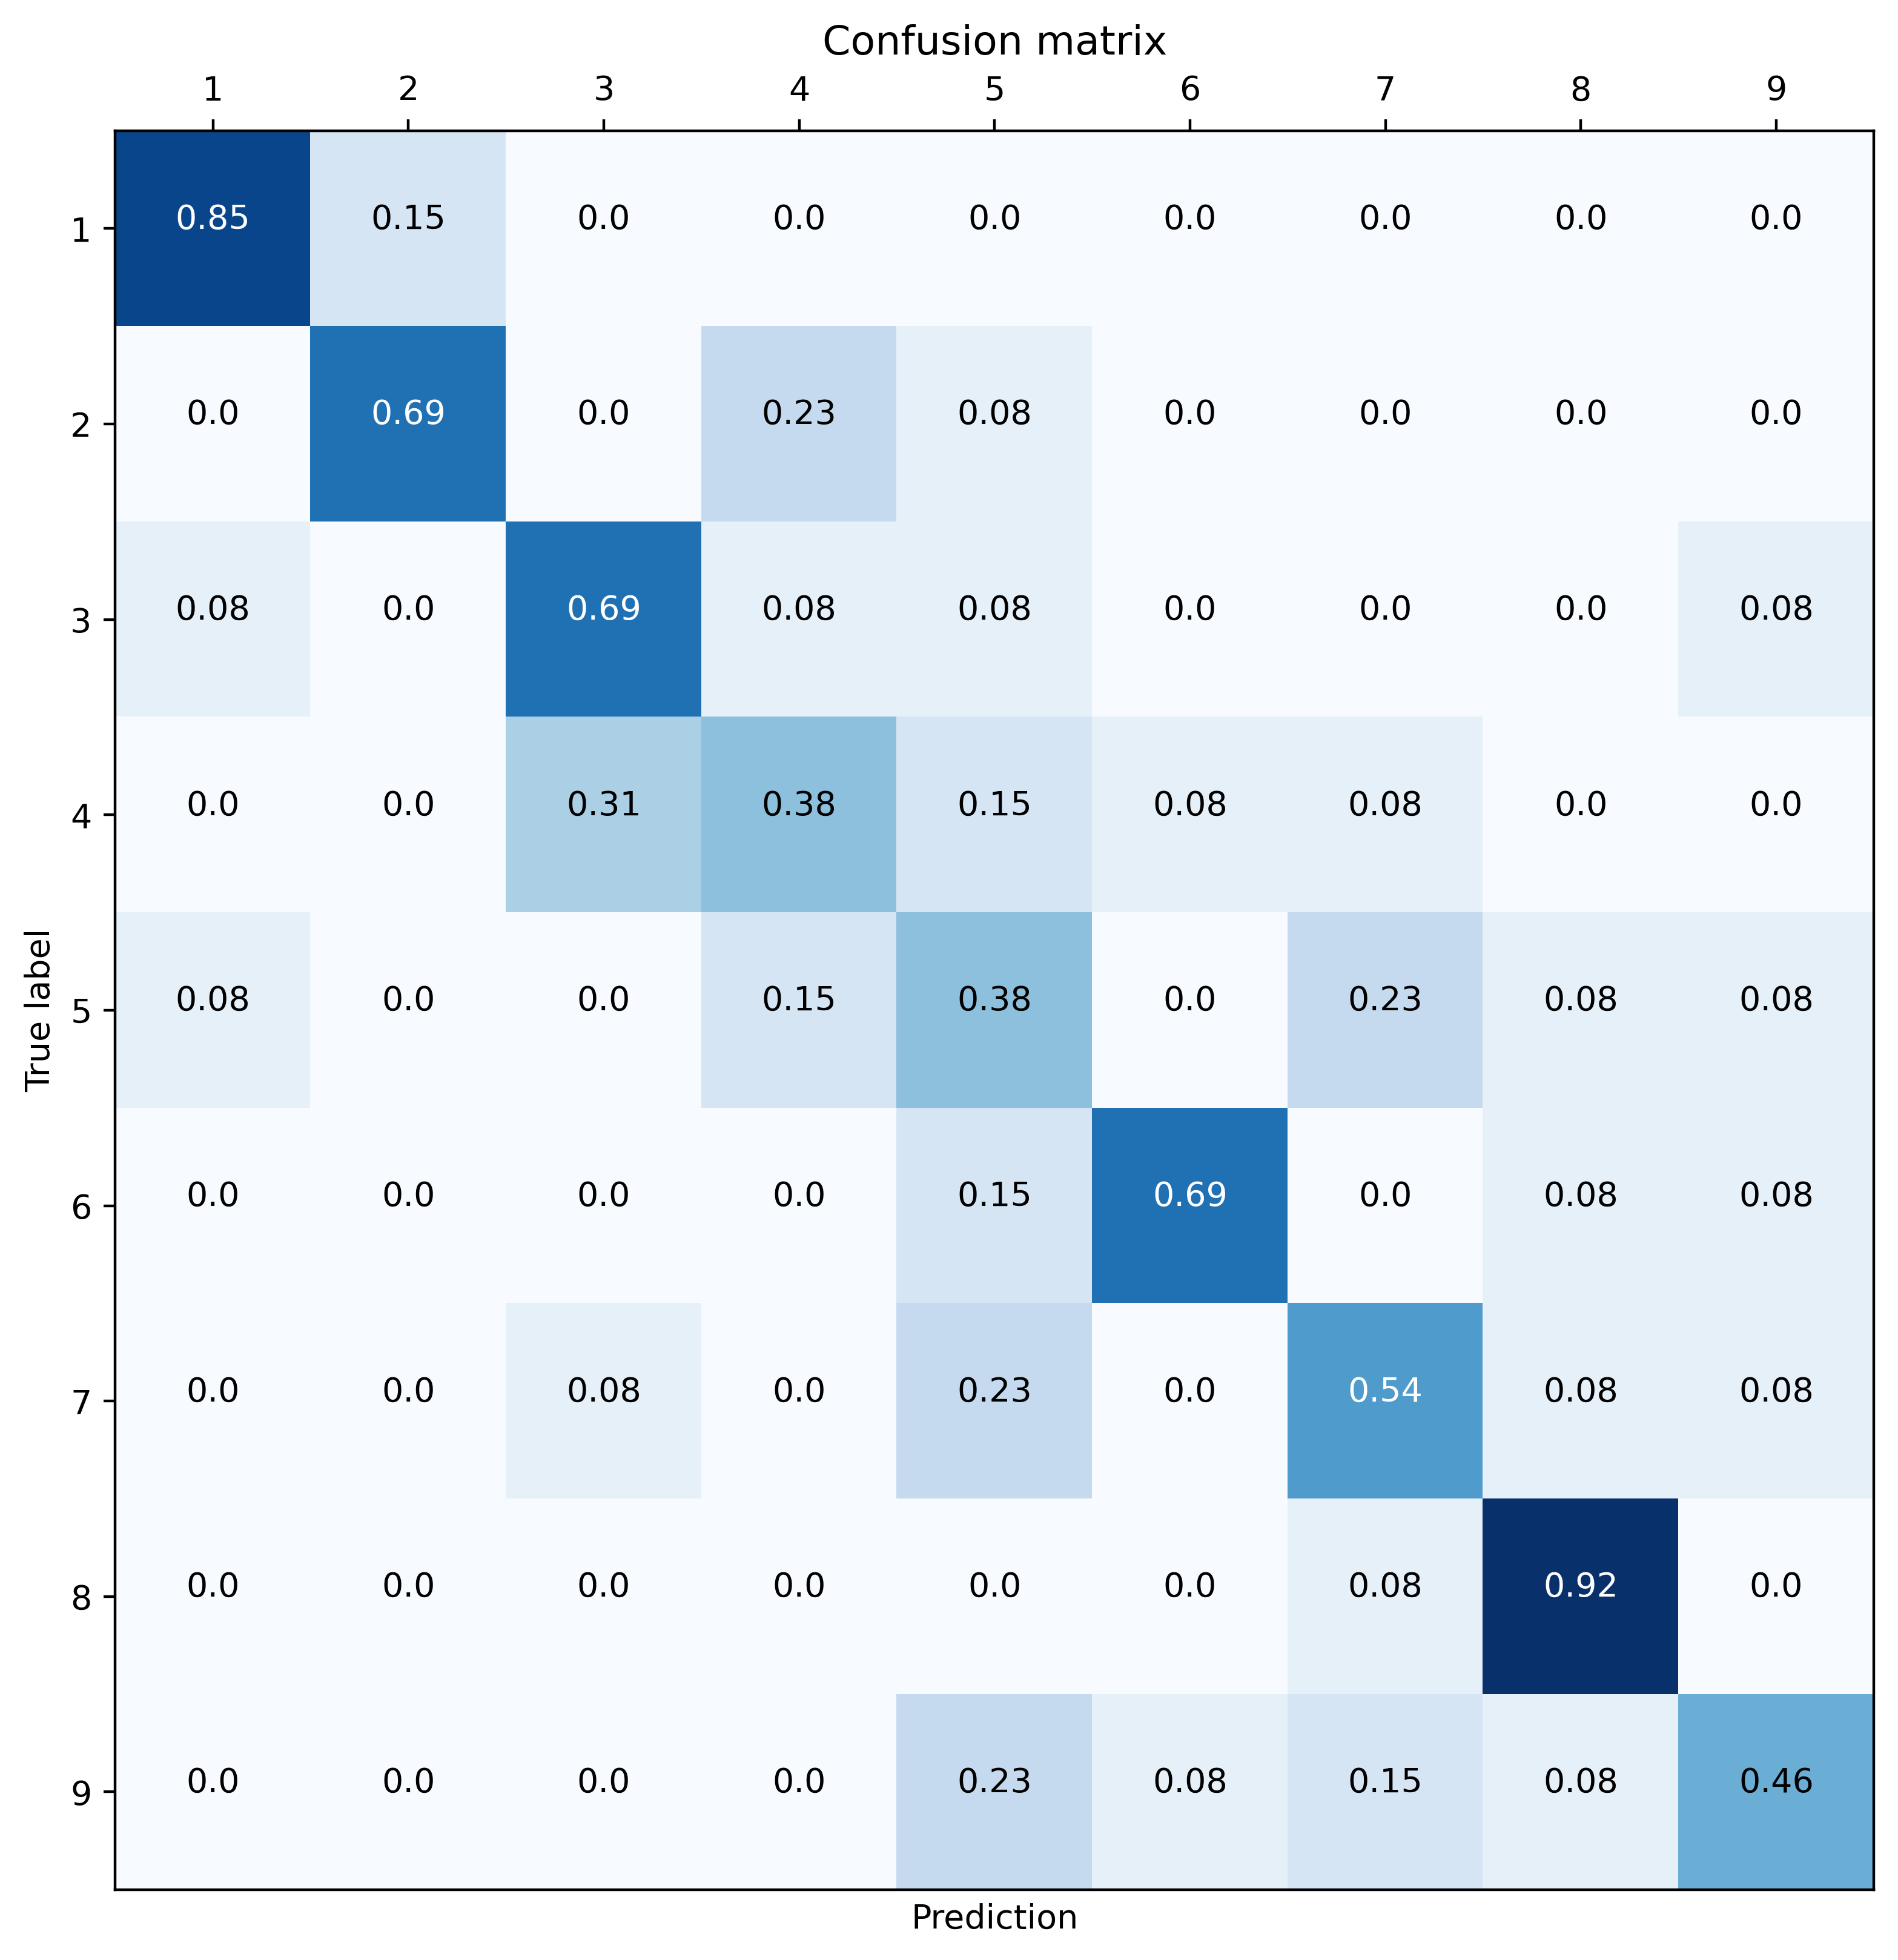

In [8]:
# confusion_matrix(labels=labels1D_test, predictions=ptest, class_names=[3, 4, 5, 6, 7])
confusion_matrix(labels=labels1D_test, predictions=ptest, class_names=np.arange(1,10,1).tolist())

In [9]:
# m = tf.keras.metrics.SparseCategoricalAccuracy()
# m.update_state(labels1D_test.reshape(1,100).shape, ptest.reshape(1,100).shape)
# m.result().numpy()

In [10]:
from sklearn.metrics import accuracy_score
mse = accuracy_score(y_true=labels1D_test, y_pred=ptest)
mse
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
# print (test_accuracy(labels1D_test.reshape(labels1D_test.shape[0],1), ptest.reshape(ptest.shape[0],1)))

0.6239316239316239

<Figure size 4800x4000 with 0 Axes>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 4800x4000 with 0 Axes>

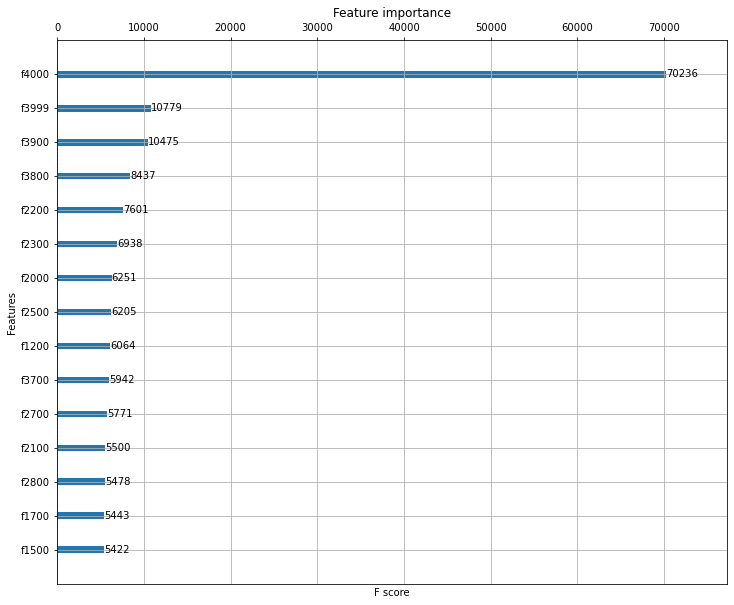

In [11]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10
plt.figure(dpi=400)
xgb.plot_importance(bst, max_num_features=15)

<Figure size 80000x50000 with 0 Axes>

<AxesSubplot:>

<Figure size 80000x50000 with 0 Axes>

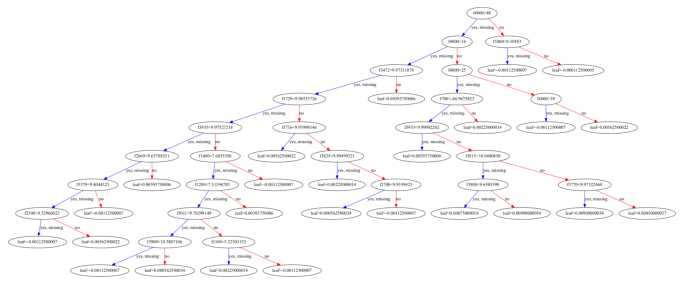

In [12]:
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 80,50
plt.figure(figsize=(80, 50), dpi=1000)
xgb.plot_tree(bst, num_trees=5)

In [13]:
element_flatten2D_test[:,-1]
labels1D_test
ptest

array([28., 23.,  2.,  1.,  2.,  8., 78.,  8.,  2., 11.,  2.,  8., 72.,
       78., 72., 78., 72., 69., 69., 37., 69., 78., 72.,  6., 80., 78.,
       78., 59.,  1.,  4., 59.,  1.,  2., 72., 78.,  1., 69., 78., 69.,
        1.,  1.,  2., 78.,  2.,  2., 72., 80.,  2., 80., 69.,  1.,  2.,
       69.,  1., 72., 78.,  2., 23.,  2., 46., 78., 14.,  2., 78., 72.,
        2., 51.,  2.,  2.,  1., 37., 23., 78., 68.,  2., 78., 72.,  2.,
        1., 80.,  1., 59.,  2., 23., 72., 72., 50., 78.,  2., 78.,  1.,
       72., 78., 23., 23., 78.,  1., 23.,  2., 41.,  1., 68., 23.,  4.,
       69.,  2., 37., 78.,  1., 78., 23.,  1., 78.,  4.,  4., 23., 78.])

array([6, 5, 3, 4, 1, 8, 3, 4, 3, 1, 5, 4, 1, 0, 8, 3, 2, 2, 1, 0, 2, 2,
       8, 0, 2, 6, 8, 5, 8, 8, 2, 8, 7, 8, 6, 4, 6, 1, 1, 8, 4, 7, 6, 4,
       6, 6, 0, 7, 0, 0, 8, 6, 1, 7, 1, 4, 7, 5, 1, 7, 2, 1, 4, 3, 6, 7,
       0, 1, 5, 4, 0, 5, 1, 2, 7, 0, 2, 7, 3, 0, 7, 2, 3, 5, 3, 6, 4, 2,
       4, 6, 7, 8, 0, 5, 3, 6, 5, 5, 7, 0, 4, 3, 5, 8, 3, 3, 0, 2, 7, 3,
       5, 6, 1, 8, 4, 5, 2])

array([7., 5., 3., 4., 1., 8., 3., 4., 4., 3., 7., 4., 1., 1., 6., 3., 2.,
       2., 1., 0., 2., 2., 6., 0., 8., 6., 8., 8., 4., 5., 2., 8., 7., 8.,
       8., 7., 6., 3., 1., 4., 8., 7., 6., 3., 4., 6., 0., 7., 0., 1., 7.,
       4., 1., 7., 1., 6., 7., 5., 1., 7., 3., 1., 4., 2., 2., 7., 0., 4.,
       4., 6., 0., 5., 1., 4., 7., 0., 2., 6., 3., 0., 7., 0., 3., 5., 2.,
       6., 0., 2., 3., 6., 7., 8., 0., 5., 5., 6., 4., 5., 7., 0., 4., 2.,
       5., 8., 6., 4., 0., 2., 7., 2., 5., 4., 3., 4., 6., 5., 2.],
      dtype=float32)

In [14]:
# np.unique(element_flatten2D_test[:,-1])

In [15]:
def get_one_hot(targets, nb_classes=81):
    ## number of layer group = 80, zero shifting ==> 80+1
    targets = targets.astype(int)
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [16]:
# element_flatten2D_test[:,-1]
# element_flatten2D_train[:,-1]
# np.concatenate((element_flatten2D_test[:,-1], element_flatten2D_train[:,-1]), axis=0)

In [17]:
import pandas as pd
df = pd.DataFrame({"layergroup":element_flatten2D_test[:,-1].astype(int),
                   "label": labels1D_test,
                   "predict": ptest.astype(int)})

df_train = pd.DataFrame({"layergroup":element_flatten2D_train[:,-1].astype(int),
                   "label": labels1D_train,
                   "predict": ptrain.astype(int)})

df_all = pd.DataFrame({"layergroup":np.concatenate((element_flatten2D_test[:,-1], element_flatten2D_train[:,-1]), axis=0).astype(int),
                   "label": np.concatenate((labels1D_test, labels1D_train), axis=0).astype(int),
                   "predict": np.concatenate((ptest, ptrain), axis=0).astype(int)})

df = df_all

In [18]:
label_lg_matrix = np.zeros([9,81])
# df.loc[df["label"] == 1, "layergroup"].tolist()
# df = df.loc[(df["label"] != df["predict"])]

for layernumber in np.arange(9):
    print(layernumber)
    layergroup_onehot = get_one_hot(np.array(df.loc[df["label"] == layernumber, "layergroup"].tolist()))
    label_lg_matrix[layernumber] = np.sum(layergroup_onehot, axis=0)

0
1
2
3
4
5
6
7
8


In [19]:
df_label_lg = pd.DataFrame(label_lg_matrix.astype(int))
df_label_lg.index += 1
df_label_lg = df_label_lg.loc[:, (df_label_lg != 0).any(axis=0)]
df_label_lg

,1,2,4,6,8,9,11,14,15,17,...,65,66,67,68,69,71,72,78,79,80
1,0,0,0,10,5,1,0,0,0,0,...,1,0,0,0,1,0,0,17,0,14
2,2,30,0,0,0,0,7,7,2,0,...,0,0,0,0,48,0,21,5,0,0
3,9,9,2,0,0,0,0,0,0,0,...,0,3,0,2,22,4,16,24,3,1
4,12,45,0,0,0,0,2,0,0,0,...,1,0,0,1,3,0,28,22,0,0
5,46,36,2,0,9,0,0,0,0,0,...,0,1,1,0,1,0,9,4,0,0
6,7,18,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
7,17,22,2,1,1,0,1,1,0,0,...,0,3,0,0,7,0,34,30,0,0
8,43,47,0,0,2,0,11,0,4,0,...,0,0,0,0,0,0,0,0,0,0
9,24,10,15,0,5,0,1,0,0,0,...,0,0,0,0,1,0,46,20,0,0


Text(87.0, 0.5, 'layer number')

Text(0.5, 86.0, 'layer group')

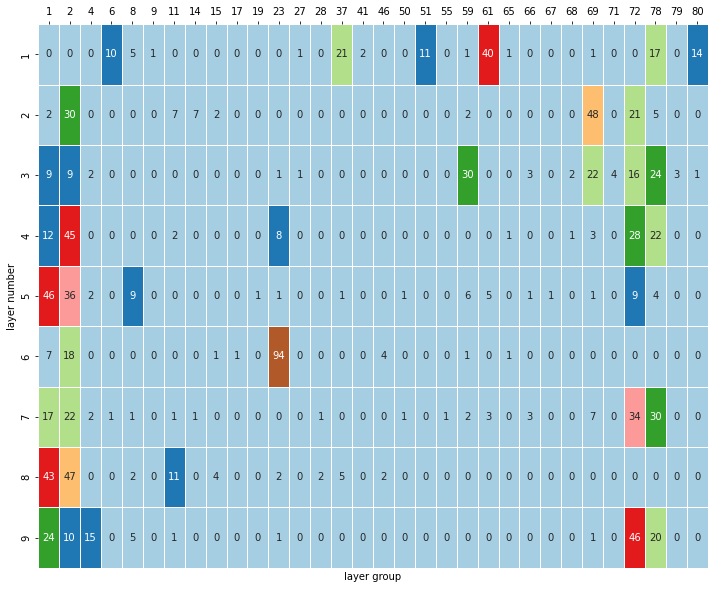

In [20]:
import seaborn as sns
import matplotlib.pylab as plt

# mask = np.zeros_like(df_label_lg)
# mask[np.triu_indices_from(mask)] = True
cmap = sns.color_palette("Paired")
ax = sns.heatmap(df_label_lg, linewidth=0.5, annot=True, cbar=False, cmap=cmap)
ax.set_ylabel("layer number")
ax.set_xlabel("layer group")
plt.show()